In [4]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

character(0)

In [5]:
library(fBasics)
library(PerformanceAnalytics)
library(xts)
library(quantmod)
library(ggplot2)
library(tseries)
library(dygraphs)
library(dplyr)
library(stats)
options(warn = - 1) 

In [6]:
start<-format(as.Date("2019-04-22"),"%Y-%m-%d")
end<-format(as.Date("2022-12-31"),"%Y-%m-%d")

#--------- Funcion de obtención de datos, particularmente los datos de precios de cierre.
precio<-function(simbolo) {
  ##---------Obtener precios de yahoo finance:
  datos<-getSymbols(simbolo,  from=start, to= end, auto.assign = FALSE)
  ##---------eliminar datos faltantes:
  datos<-na.omit(datos)
  ##--------Mantener el precio de interis:
  datos<-datos[,4]
  assign(simbolo, datos, envir = .GlobalEnv)
}

In [7]:
precio("RYLD")  
precio("TSLA")  
precio("TM") 
precio("GM") 

In [8]:
prices<-merge.xts(`RYLD`,`TSLA`, `TM`, `GM`)
dim(prices)
colnames(prices)<-c("RYLD","TSLA", "TM", "GM")
dygraph(prices) %>%
  dyAxis("y", label = "Prices") %>%
  dyOptions(colors = RColorBrewer::brewer.pal(4, "Set1"))


[1] 933   4

HTML widgets cannot be represented in plain text (need html)

In [9]:
head(prices)

             RYLD     TSLA     TM    GM
2019-04-22 24.995 17.51667 124.16 39.50
2019-04-23 25.157 17.59333 124.94 39.83
2019-04-24 25.189 17.24400 122.88 39.72
2019-04-25 25.130 16.50867 123.19 39.11
2019-04-26 25.225 15.67600 123.62 39.68
2019-04-29 25.250 16.09800 123.81 40.01

**1. PPREPROCESAMIENTO:**

In [15]:
library(vars)
ryld=ts(prices$RYLD, start= c(2019,04,22), frequency = 365)
tesla=ts(prices$TSLA, start= c(2019,04,22), frequency = 365)
tm= ts(prices$TM, start= c(2019,04,22), frequency = 365)
gm= ts(prices$GM, start= c(2019,04,22), frequency = 365)



**2. SPLIT EN TRAINING Y TEST**

In [16]:
h <- round(nrow(prices)*0.05, digits = 0 )
library(TSstudio)

ryld.split =ts_split(ts.obj = ryld, sample.out = h)
ryld.training <- ryld.split$train
ryld.testing <- ryld.split$test

tesla.split =ts_split(ts.obj = tesla, sample.out = h)
tesla.training <- tesla.split$train
tesla.testing <- tesla.split$test

tm.split =ts_split(ts.obj = tm, sample.out = h)
tm.training <- tm.split$train
tm.testing <- tm.split$test

gm.split =ts_split(ts.obj = gm, sample.out = h)
gm.training <- gm.split$train
gm.testing <- gm.split$test

nrow(ryld.training)
h

[1] 886

[1] 47

In [10]:
#h <- round(nrow(prices)*0.05, digits = 0 )
#h
#prices.training <- prices[1:(nrow(prices) - h), ]
#prices.testing <- prices[(nrow(prices) - h + 1):nrow(prices), ]
#nrow(prices.training)
#nrow(prices.testing)



**3.PROPIEDADES DE LA SERIE: PRUEBA COINTEGRACION**

In [17]:
library(urca)
library(vars)
#NIVEL DE REGRESION
dataVAR=ts.intersect(ryld.training, tesla.training, tm.training, gm.training) %>% na.omit()
nivelk=VARselect(dataVAR, lag.max = 7, type = "const")
nivelk$selection

AIC(n)  HQ(n)  SC(n) FPE(n) 
     3      1      1      3

**Johansen Test**

Se acepta la hipotesis nula de r=0 que no estan cointengradas

In [18]:
johatest=ca.jo(dataVAR, type = "trace", K=3, ecdet ="none", spec = "longrun") #K is the number of lags to use in the vector autoregressive model and is set this to the minimum, K=2.
summary(johatest)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , with linear trend 

Eigenvalues (lambda):
[1] 0.024792323 0.012904110 0.004739775 0.001928430

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 3 |  1.70  6.50  8.18 11.65
r <= 2 |  5.90 15.66 17.95 23.52
r <= 1 | 17.37 28.71 31.52 37.22
r = 0  | 39.54 45.23 48.28 55.43

Eigenvectors, normalised to first column:
(These are the cointegration relations)

                  ryld.training.l3 tesla.training.l3 tm.training.l3
ryld.training.l3         1.0000000        1.00000000    1.000000000
tesla.training.l3        0.0354555        0.01332713   -0.004482784
tm.training.l3          -0.1593612        0.14784759    0.012446804
gm.training.l3          -0.1516941       -0.52249874   -0.033052208
                  gm.training.l3
ryld.training.l3      1.00000000
tesla.training.l3    -0.23084670
tm.training.l3       -0.09786569
gm.training.l3       -1.479

**4.Modelo VAR (MTS) para analizar estacionariedad de la serie a traves de los PHI componentes del modelo VAR**

In [19]:
library(MTS)
m2=VARorder(dataVAR)


Attaching package: ‘MTS’


The following object is masked from ‘package:vars’:

    VAR


The following object is masked from ‘package:TTR’:

    VMA




selected order: aic =  3 
selected order: bic =  1 
selected order: hq =  3 
Summary table:  
       p     AIC     BIC      HQ       M(p) p-value
 [1,]  0 19.1002 19.1002 19.1002     0.0000  0.0000
 [2,]  1  2.5494  2.6358  2.5824 14389.1243  0.0000
 [3,]  2  2.5316  2.7044  2.5977    46.5819  0.0001
 [4,]  3  2.4832  2.7425  2.5823    72.6151  0.0000
 [5,]  4  2.5115  2.8572  2.6437     6.7076  0.9785
 [6,]  5  2.5226  2.9548  2.6878    21.2669  0.1685
 [7,]  6  2.5367  3.0554  2.7350    18.6596  0.2867
 [8,]  7  2.5528  3.1579  2.7841    16.8925  0.3926
 [9,]  8  2.5443  3.2358  2.8086    37.4936  0.0018
[10,]  9  2.5524  3.3304  2.8499    23.3347  0.1051
[11,] 10  2.5440  3.4085  2.8745    37.0236  0.0021
[12,] 11  2.5562  3.5071  2.9197    19.7991  0.2294
[13,] 12  2.5589  3.5962  2.9554    27.5603  0.0357
[14,] 13  2.5773  3.7010  3.0069    14.5011  0.5614


In [20]:
m2_mts=MTS::VAR(dataVAR, 3)

Constant term: 
Estimates:  0.2608443 0.03875506 2.140639 0.6457193 
Std.Error:  0.1194969 3.693215 1.041164 0.4939372 
AR coefficient matrix 
AR( 1 )-matrix 
        [,1]     [,2]     [,3]    [,4]
[1,]  0.8516 0.000395 -0.00224  0.0167
[2,]  1.1091 0.951521 -0.00861 -0.2976
[3,] -1.0731 0.015418  0.99812  0.0873
[4,] -0.0154 0.010816 -0.01228  0.9725
standard error 
       [,1]    [,2]    [,3]   [,4]
[1,] 0.0429 0.00120 0.00469 0.0105
[2,] 1.3262 0.03700 0.14484 0.3254
[3,] 0.3739 0.01043 0.04083 0.0917
[4,] 0.1774 0.00495 0.01937 0.0435
AR( 2 )-matrix 
      [,1]     [,2]      [,3]     [,4]
[1,] 0.423 -0.00271  0.001559 -0.03533
[2,] 1.135  0.03052 -0.003307  0.28620
[3,] 1.311 -0.02049  0.000282  0.03689
[4,] 0.496 -0.01826 -0.022626 -0.00889
standard error 
       [,1]    [,2]    [,3]   [,4]
[1,] 0.0557 0.00164 0.00668 0.0143
[2,] 1.7200 0.05058 0.20654 0.4432
[3,] 0.4849 0.01426 0.05823 0.1249
[4,] 0.2300 0.00676 0.02762 0.0593
AR( 3 )-matrix 
       [,1]    [,2]      [,3]    [,4]

In [21]:
phi1=m2_mts$Phi[,c(1,2,3,4)]
phi2=m2_mts$Phi[,c(5,6,7,8)]
phi3=m2_mts$Phi[,c(9,10,11,12)]
eigen(phi1)
eigen(phi2)
eigen(phi3)

eigen() decomposition
$values
[1] 1.0192580+0.0000000i 0.9481730+0.0470278i 0.9481730-0.0470278i
[4] 0.8581661+0.0000000i

$vectors
               [,1]                   [,2]                   [,3]          [,4]
[1,] -0.03158217+0i -0.01098268-0.0280284i -0.01098268+0.0280284i -0.1008885+0i
[2,]  0.20874559+0i  0.89878100+0.0000000i  0.89878100+0.0000000i  0.6380399+0i
[3,]  0.95823126+0i -0.15387517-0.3328883i -0.15387517+0.3328883i -0.7476231+0i
[4,] -0.19292668+0i -0.02636910-0.2368522i -0.02636910+0.2368522i -0.1542282+0i


eigen() decomposition
$values
[1] 0.38656720+0.00000000i 0.01681665+0.09875068i 0.01681665-0.09875068i
[4] 0.02507095+0.00000000i

$vectors
              [,1]                    [,2]                    [,3]
[1,] -0.1907016+0i  0.00234623-0.01874461i  0.00234623+0.01874461i
[2,] -0.7382436+0i -0.88544695+0.00000000i -0.88544695+0.00000000i
[3,] -0.6244227+0i -0.29049724-0.27463598i -0.29049724+0.27463598i
[4,] -0.1694862+0i  0.02974608-0.23436816i  0.02974608+0.23436816i
                [,4]
[1,]  0.004340345+0i
[2,]  0.847353775+0i
[3,] -0.529542088+0i
[4,] -0.039470471+0i


eigen() decomposition
$values
[1] -0.24414546+0.00000000i -0.00080573+0.06296461i -0.00080573-0.06296461i
[4] -0.02514495+0.00000000i

$vectors
             [,1]                  [,2]                  [,3]           [,4]
[1,] 0.1067061+0i 0.0114975-0.02074837i 0.0114975+0.02074837i -0.00903821+0i
[2,] 0.9754436+0i 0.8514298+0.00000000i 0.8514298+0.00000000i -0.96402067+0i
[3,] 0.1463228+0i 0.3651923+0.25675054i 0.3651923-0.25675054i  0.26469233+0i
[4,] 0.1253523+0i 0.1215964-0.24583076i 0.1215964+0.24583076i -0.02281279+0i


**5.MODELADO CON DIFERENCIAS**

In [22]:
#Diferencias y realizar test de estacionariedad
ryld.dif=diff.xts(prices$RYLD)[-1,]
tesla.dif=diff.xts(prices$TSLA)[-1,]
tm.dif= diff.xts(prices$TM)[-1,]
gm.dif= diff.xts(prices$GM)[-1,]

adf.test(ryld.dif)
adf.test(tesla.dif)
adf.test(tm.dif)
adf.test(gm.dif)



	Augmented Dickey-Fuller Test

data:  ryld.dif
Dickey-Fuller = -8.0814, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  tesla.dif
Dickey-Fuller = -9.2478, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  tm.dif
Dickey-Fuller = -10.768, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  gm.dif
Dickey-Fuller = -9.895, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary


In [23]:
ryld.training.dif<-diff(ryld.training)
ryld.testing.dif<-diff(ryld.testing)
tesla.training.dif<-diff(tesla.training)
tesla.testing.dif<-diff(tesla.testing)
tm.training.dif<-diff(tm.training)
tm.testing.dif<-diff(tm.testing)
gm.training.dif<-diff(gm.training)
gm.testing.dif<-diff(gm.testing)

dataVAR=ts.intersect(ryld.training.dif, tesla.training.dif,tm.training.dif,gm.training.dif) %>% na.omit()
#Nuevamente, seleccionamos nivel autorregresivo:
nivelk=VARselect(dataVAR, lag.max = 7, type = "const")
nivelk$selection



AIC(n)  HQ(n)  SC(n) FPE(n) 
     2      2      1      2

**Series en Equilibrio**

In [24]:
johatest=ca.jo(dataVAR, type = "trace", K=2, ecdet ="none", spec = "longrun")
summary(johatest)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , with linear trend 

Eigenvalues (lambda):
[1] 0.3567214 0.3396544 0.3166051 0.2624927

Values of teststatistic and critical values of test:

            test 10pct  5pct  1pct
r <= 3 |  268.86  6.50  8.18 11.65
r <= 2 |  605.00 15.66 17.95 23.52
r <= 1 |  971.44 28.71 31.52 37.22
r = 0  | 1361.00 45.23 48.28 55.43

Eigenvectors, normalised to first column:
(These are the cointegration relations)

                      ryld.training.dif.l2 tesla.training.dif.l2
ryld.training.dif.l2            1.00000000              1.000000
tesla.training.dif.l2          -0.03204478              1.879678
tm.training.dif.l2              0.08215697             -1.851217
gm.training.dif.l2             -0.60291616             -8.109563
                      tm.training.dif.l2 gm.training.dif.l2
ryld.training.dif.l2           1.0000000        1.000000000
tesla.training.dif.l2         -0.1003510       -0.00

**MODELADO VAR con DIFERENCIAS [LIBRERIA VARS]**

In [25]:
m1_dif <- vars::VAR(y=dataVAR, p=2)
summary(m1_dif)


VAR Estimation Results:
Endogenous variables: ryld.training.dif, tesla.training.dif, tm.training.dif, gm.training.dif 
Deterministic variables: const 
Sample size: 883 
Log Likelihood: -6062.921 
Roots of the characteristic polynomial:
0.5707 0.4178 0.2799 0.2799 0.2761 0.2761 0.1395 0.09844
Call:
vars::VAR(y = dataVAR, p = 2)


Estimation results for equation ryld.training.dif: 
ryld.training.dif = ryld.training.dif.l1 + tesla.training.dif.l1 + tm.training.dif.l1 + gm.training.dif.l1 + ryld.training.dif.l2 + tesla.training.dif.l2 + tm.training.dif.l2 + gm.training.dif.l2 + const 

                        Estimate Std. Error t value Pr(>|t|)    
ryld.training.dif.l1  -0.1404906  0.0427211  -3.289  0.00105 ** 
tesla.training.dif.l1  0.0003732  0.0011952   0.312  0.75490    
tm.training.dif.l1    -0.0017988  0.0046631  -0.386  0.69977    
gm.training.dif.l1     0.0152832  0.0104306   1.465  0.14322    
ryld.training.dif.l2   0.2856286  0.0428700   6.663 4.75e-11 ***
tesla.training.dif.l

**Metricas De Error on Test (Librearia VARS)**

In [26]:
pred <- predict(m1_dif, n.ahead=h-1)
ryld.pred<-pred$fcst[1]$ryld.training.dif
yardstick::rmse(data.frame(Y=as.matrix(ryld.testing.dif)), truth = RYLD, estimate = ryld.pred[,1])
yardstick::mae(data.frame(Y=as.matrix(ryld.testing.dif)), truth = RYLD, estimate = ryld.pred[,1])
yardstick::rmse(data.frame(Y=as.matrix(ryld.testing.dif)), truth = RYLD, estimate = ryld.pred[,2])
yardstick::mae(data.frame(Y=as.matrix(ryld.testing.dif)), truth = RYLD, estimate = ryld.pred[,2])
yardstick::rmse(data.frame(Y=as.matrix(ryld.testing.dif)), truth = RYLD, estimate = ryld.pred[,3])
yardstick::mae(data.frame(Y=as.matrix(ryld.testing.dif)), truth = RYLD, estimate = ryld.pred[,3])
yardstick::rmse(data.frame(Y=as.matrix(ryld.testing.dif)), truth = RYLD, estimate = ryld.pred[,4])
yardstick::mae(data.frame(Y=as.matrix(ryld.testing.dif)), truth = RYLD, estimate = ryld.pred[,4])

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.1320597


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
mae,standard,0.1001395


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.5478245


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
mae,standard,0.5317769


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.5587973


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
mae,standard,0.5428878


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.5648261


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
mae,standard,0.5490715


[1] 885

ERROR: Error in plot(data_training$ID, data_training$RYLD, type = "l") + lines(data_testing$ID, : non-numeric argument to binary operator


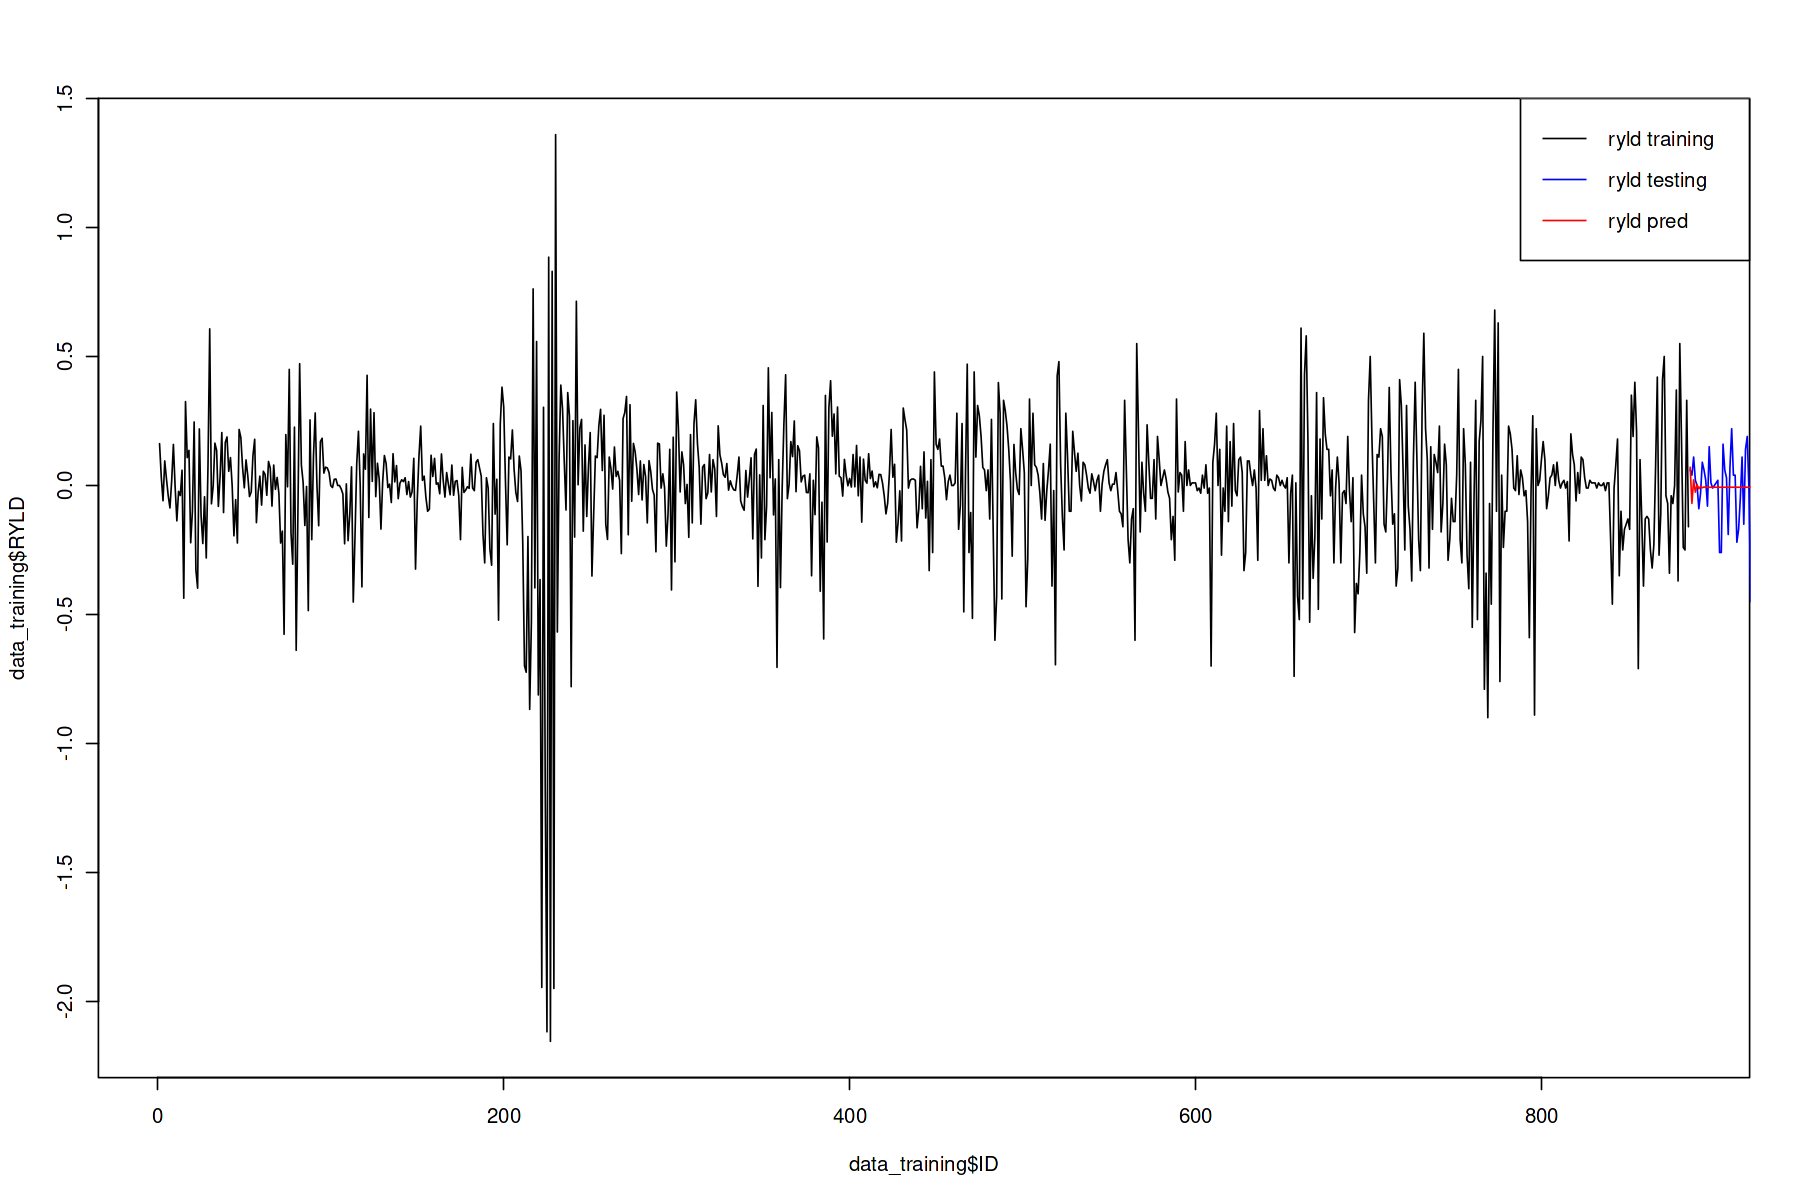

In [27]:
data_training= data.frame(Y=as.matrix(ryld.training.dif))
data_training <- cbind(ID = 1:nrow(data_training), data_training)  
nrow(data_training)

lim_inf<-nrow(data_training) +1
lim_sup<-lim_inf + nrow(ryld.testing.dif) -1
data_testing<- data.frame(Y=as.matrix(ryld.testing.dif))
data_testing <- cbind(ID = lim_inf:lim_sup, data_testing)  

data_testing$pred= ryld.pred[,1]

options(repr.plot.width = 15, repr.plot.height =10)
plot(data_training$ID, data_training$RYLD,type = "l") +
lines(data_testing$ID, data_testing$RYLD,type = "l", col='blue') +
lines(data_testing$ID, data_testing$pred, type = "l", col='red') +
legend("topright",                           
       c("ryld training", "ryld testing", "ryld pred"),
       lty = 1,
       col = c('black','blue','red'))

**PRONOSTICO HACIA ADELANTE CON TODA LA SERIE**

In [28]:
dataVAR_all=ts.intersect(diff(ryld), diff(tesla), diff(tm),diff(gm)) %>% na.omit()
pronostico<-predict(m1_dif, n.ahead=10)


**RECUPERACION NIVEL**

In [30]:
#Como diferenciamos, recuperamos el nivel.

dato=merge.xts(prices$RYLD,prices$TSLA , join='inner') %>% na.omit()
price=merge.xts(dato, prices$TM, join="inner") %>% na.omit()
datos=merge.xts(price, prices$GM, join="inner") %>% na.omit()
nhor=10 #pasos en el pronóstico.
nr_lev <- nrow(datos)
mr_lev= as.matrix(datos)
m.varf_lev_ft <- rbind(mr_lev, matrix(NA, nhor,4 ))
m.ft_df <- do.call(cbind,lapply(pronostico$fcst, 
                                function(x) x[,"fcst"]))
for(h in (nr_lev+1):(nr_lev+nhor)) {
  hf <- h - nr_lev
  m.varf_lev_ft[h,] <- m.varf_lev_ft[h-1,] + m.ft_df[hf,]
}


**VISUALIZACION**

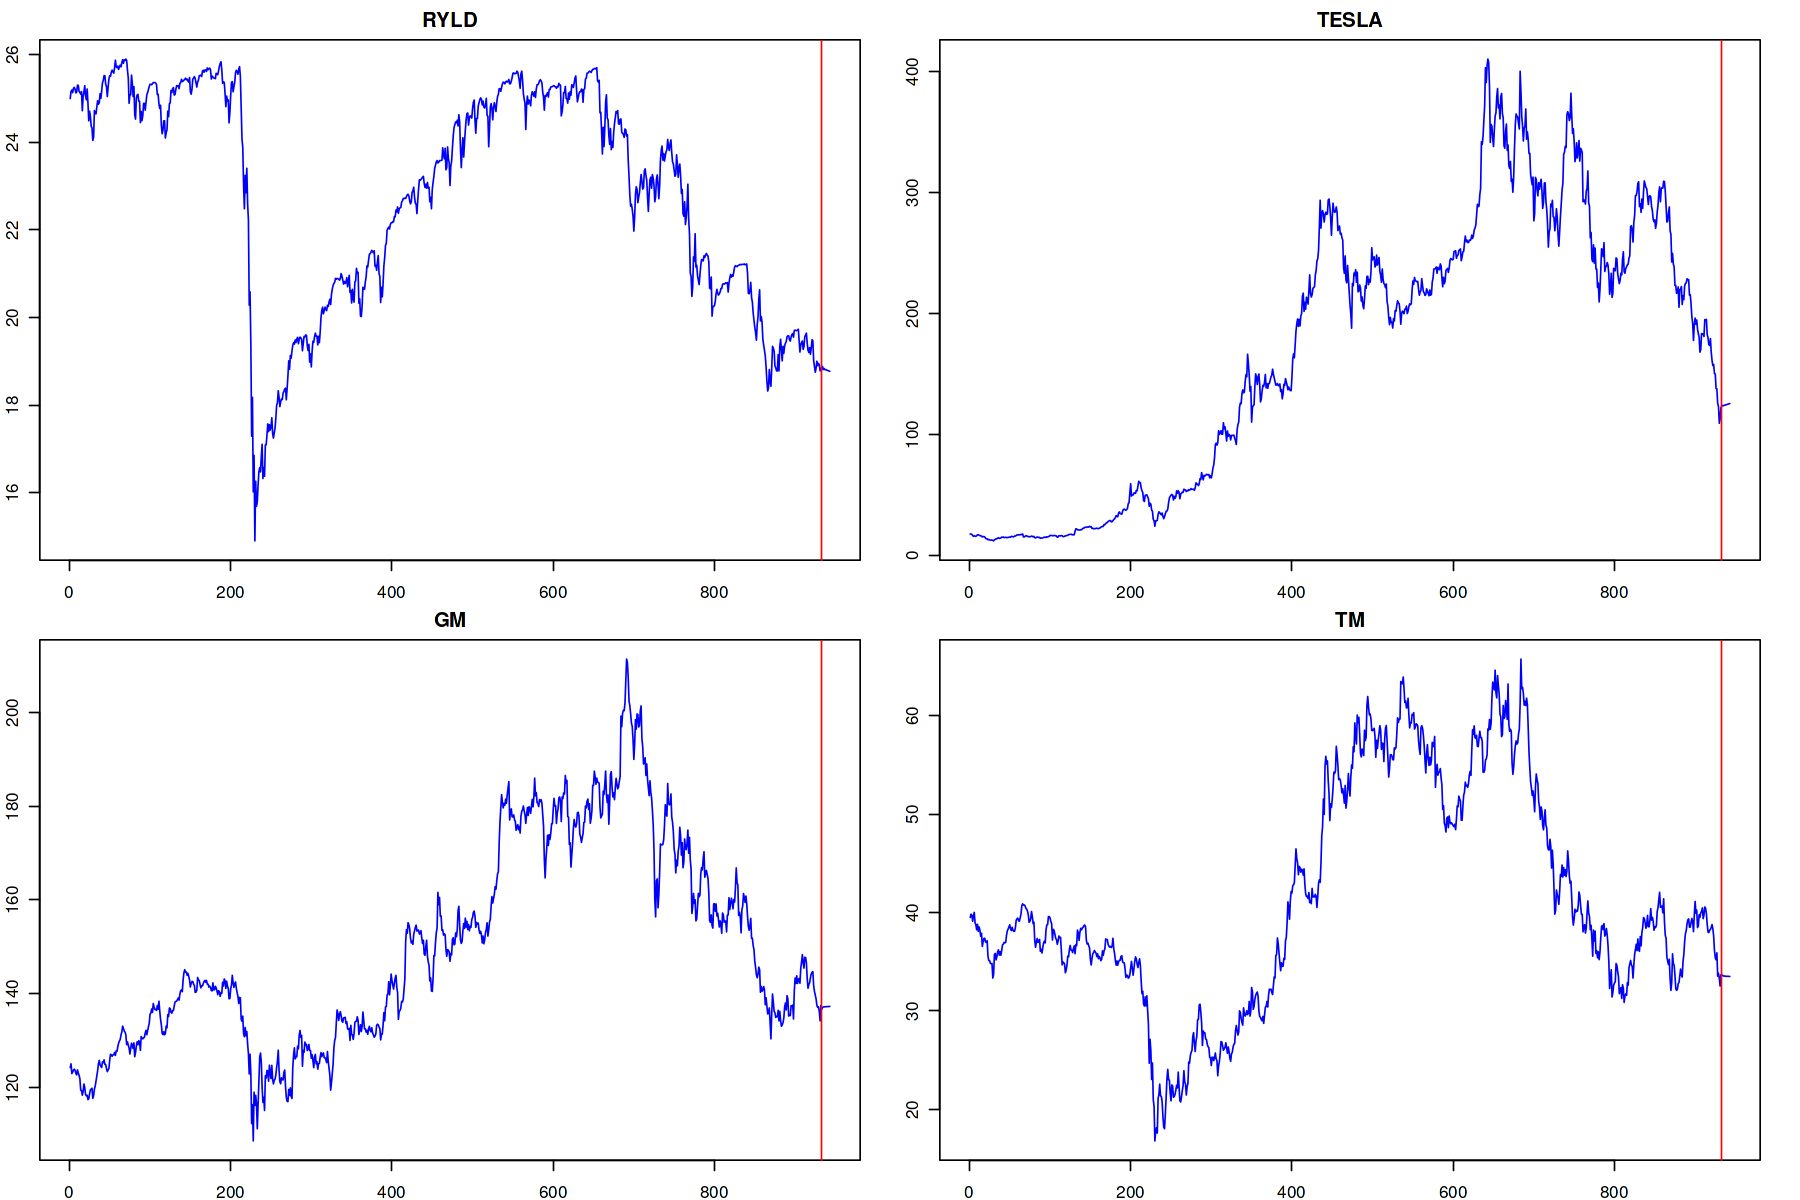

In [31]:
#Visualizacion
str.main=c("RYLD", "TESLA", "GM","TM")
par(mfrow=c(2,2), mar=c(2,2,2,2))

for(i in 1:4) {
  df <- m.varf_lev_ft[,i]
  matplot(df, type=c("l"), col = c("blue"), 
          main = str.main[i]) 
  abline(v=nr_lev, col="red")
}

**IMPULSO RESPUESTA**

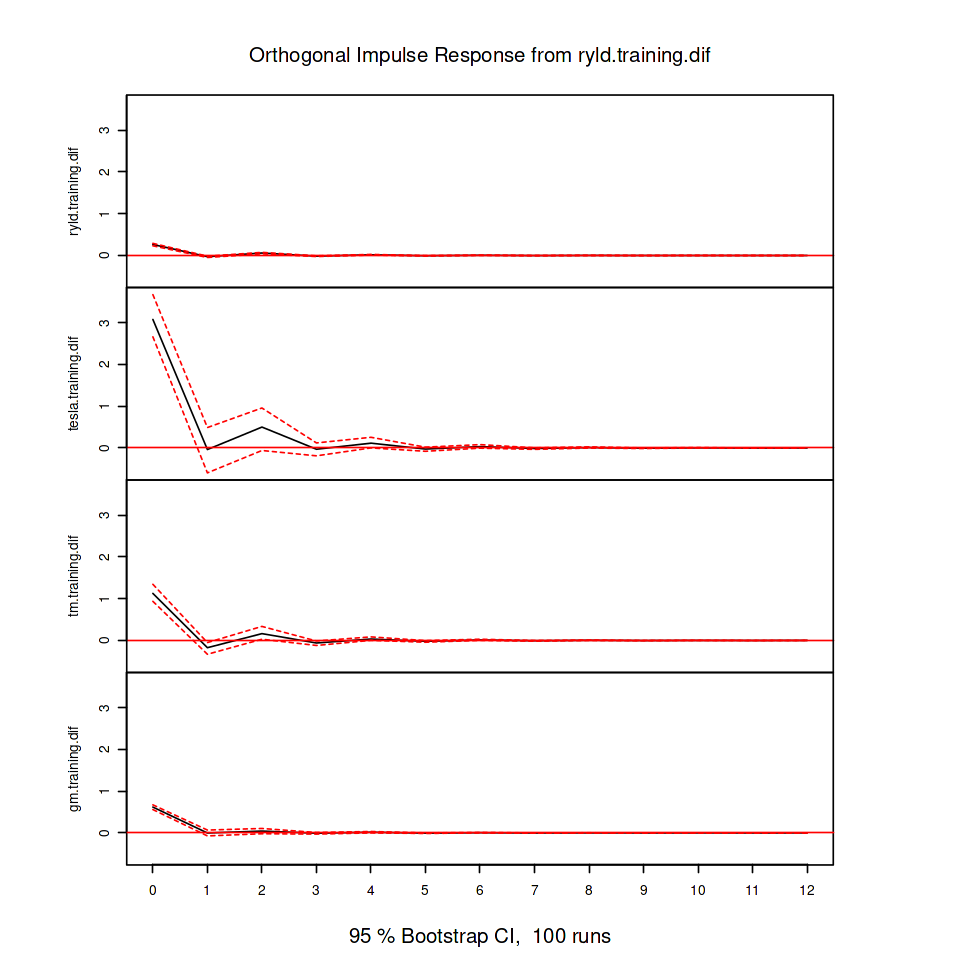

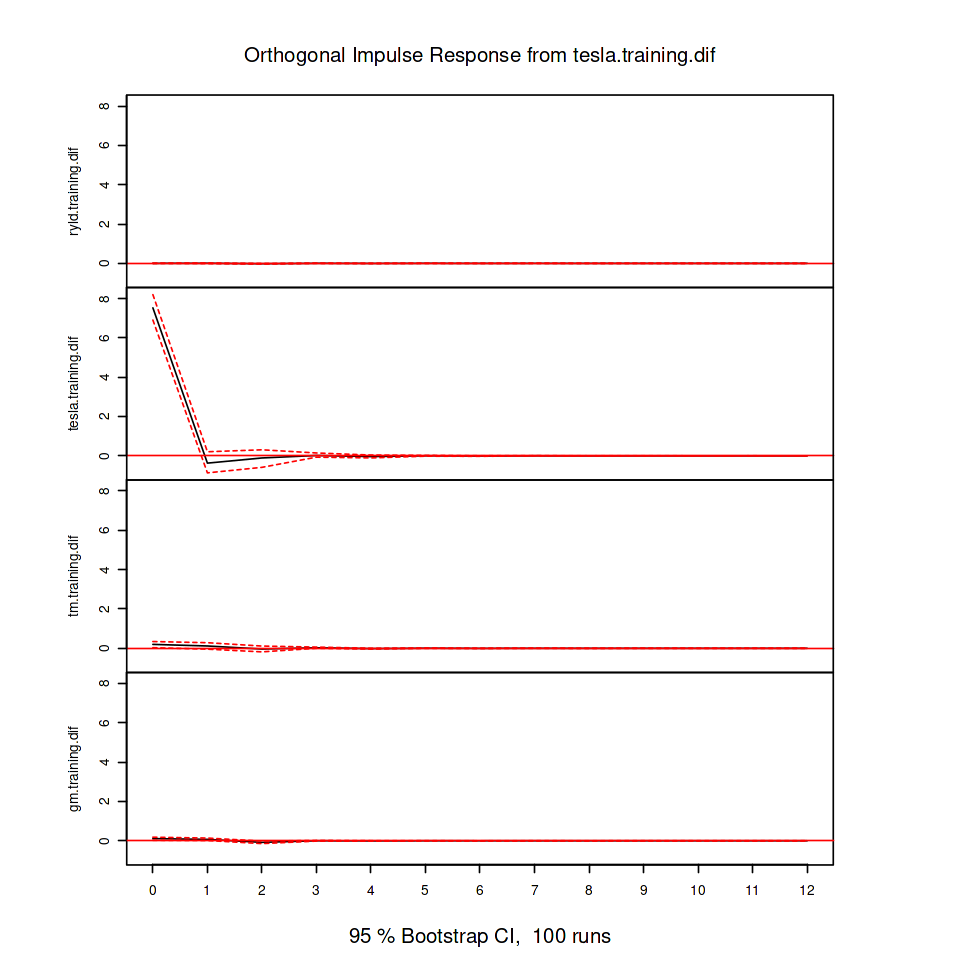

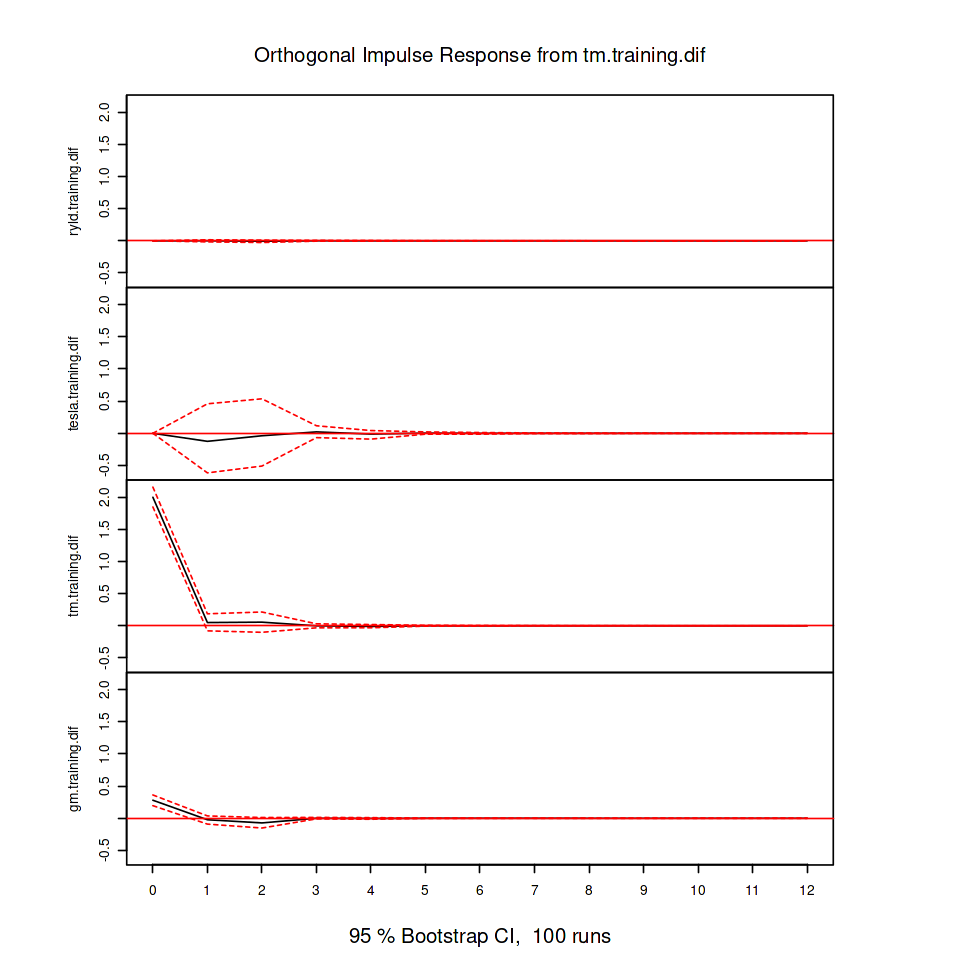

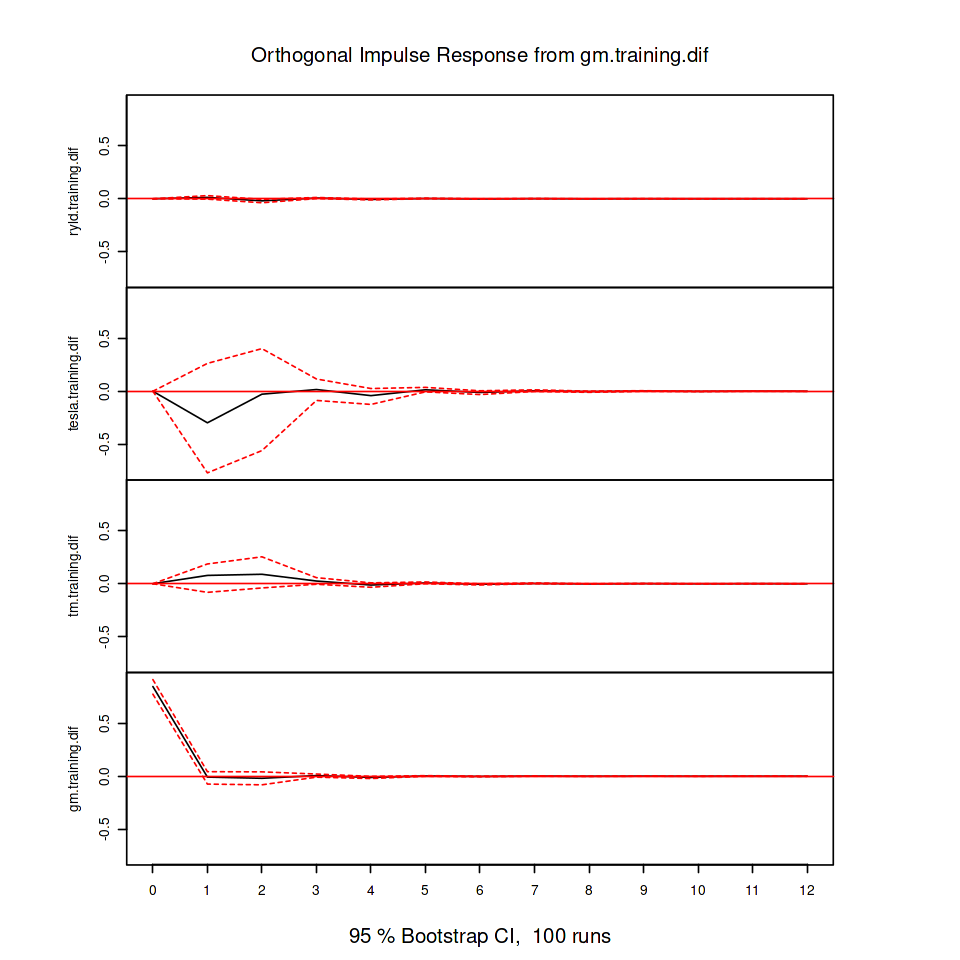

In [79]:
options(repr.plot.width = 8, repr.plot.height =8)
m1irf = irf(m1_dif, n.ahead = 12, boot = TRUE)
plot(m1irf) 

**MODELADO VAR con DIFERENCIAS [LIBRERIA MTS]**

In [32]:
library(MTS)
dataVAR=ts.intersect(ryld.training.dif, tesla.training.dif,tm.training.dif,gm.training.dif) %>% na.omit()
order=VARorder(dataVAR)
order


selected order: aic =  2 
selected order: bic =  0 
selected order: hq =  2 
Summary table:  
       p    AIC    BIC     HQ    M(p) p-value
 [1,]  0 2.5661 2.5661 2.5661  0.0000  0.0000
 [2,]  1 2.5449 2.6314 2.5780 49.7083  0.0000
 [3,]  2 2.4953 2.6684 2.5615 73.9426  0.0000
 [4,]  3 2.5222 2.7818 2.6215  7.9571  0.9501
 [5,]  4 2.5303 2.8764 2.6626 24.0192  0.0891
 [6,]  5 2.5446 2.9772 2.7100 18.5593  0.2922
 [7,]  6 2.5595 3.0786 2.7580 18.0183  0.3228
 [8,]  7 2.5537 3.1593 2.7852 35.3461  0.0036
 [9,]  8 2.5613 3.2535 2.8259 23.9210  0.0912
[10,]  9 2.5573 3.3360 2.8550 33.5402  0.0063
[11,] 10 2.5694 3.4346 2.9002 19.9465  0.2226
[12,] 11 2.5765 3.5282 2.9403 24.0472  0.0885
[13,] 12 2.5973 3.6355 2.9942 12.6425  0.6987
[14,] 13 2.6195 3.7443 3.0495 11.3889  0.7849


$aic
 [1] 2.566123 2.544915 2.495342 2.522232 2.530281 2.544618 2.559490 2.553695
 [9] 2.561324 2.557291 2.569431 2.576494 2.597282 2.619525

$aicor
[1] 2

$bic
 [1] 2.566123 2.631434 2.668381 2.781789 2.876357 2.977213 3.078605 3.159328
 [9] 3.253477 3.335963 3.434622 3.528204 3.635511 3.744274

$bicor
[1] 0

$hq
 [1] 2.566123 2.577992 2.561497 2.621465 2.662591 2.710005 2.757955 2.785237
 [9] 2.825945 2.854989 2.900207 2.940347 2.994212 3.049534

$hqor
[1] 2

$Mstat
 [1] 49.708321 73.942619  7.957102 24.019182 18.559279 18.018273 35.346069
 [8] 23.921044 33.540214 19.946536 24.047220 12.642502 11.388947

$Mpv
 [1] 2.551091e-05 2.014743e-09 9.501332e-01 8.908639e-02 2.921782e-01
 [6] 3.228280e-01 3.562752e-03 9.124321e-02 6.262547e-03 2.226383e-01
[11] 8.847822e-02 6.986950e-01 7.848654e-01

In [33]:
m2_mts=MTS::VAR(dataVAR, 2)

Constant term: 
Estimates:  -0.005413425 0.2545004 0.00738861 -0.00198523 
Std.Error:  0.008886437 0.2742414 0.07765216 0.03683012 
AR coefficient matrix 
AR( 1 )-matrix 
        [,1]      [,2]    [,3]     [,4]
[1,] -0.1405  0.000373 -0.0018  0.01528
[2,]  1.2525 -0.043873 -0.0131 -0.35200
[3,] -1.0907  0.014009  0.0122  0.09280
[4,] -0.0555  0.009925 -0.0102 -0.00975
standard error 
       [,1]    [,2]    [,3]   [,4]
[1,] 0.0427 0.00120 0.00466 0.0104
[2,] 1.3184 0.03688 0.14391 0.3219
[3,] 0.3733 0.01044 0.04075 0.0911
[4,] 0.1771 0.00495 0.01933 0.0432
AR( 2 )-matrix 
      [,1]     [,2]      [,3]    [,4]
[1,] 0.286 -0.00234 -0.000191 -0.0206
[2,] 2.394 -0.01228 -0.016173 -0.0696
[3,] 0.243 -0.00693  0.012395  0.1269
[4,] 0.442 -0.00867 -0.032857 -0.0179
standard error 
       [,1]    [,2]    [,3]   [,4]
[1,] 0.0429 0.00120 0.00466 0.0104
[2,] 1.3230 0.03689 0.14371 0.3213
[3,] 0.3746 0.01045 0.04069 0.0910
[4,] 0.1777 0.00495 0.01930 0.0431
  
Residuals cov-mtx: 
           [,1]   

**Analisis de Residuales**

Ljung-Box Statistics:  
          m       Q(m)     df    p-value
 [1,]   1.000     0.193 -20.000     1.00
 [2,]   2.000     0.890  -4.000     1.00
 [3,]   3.000     6.124  12.000     1.00
 [4,]   4.000    32.267  28.000     0.26
 [5,]   5.000    49.949  44.000     0.25
 [6,]   6.000    66.022  60.000     0.28
 [7,]   7.000    99.954  76.000     0.03
 [8,]   8.000   126.774  92.000     0.01
 [9,]   9.000   167.835 108.000     0.00
[10,]  10.000   183.934 124.000     0.00
[11,]  11.000   203.825 140.000     0.00
[12,]  12.000   215.183 156.000     0.00
[13,]  13.000   226.861 172.000     0.00
[14,]  14.000   250.189 188.000     0.00
[15,]  15.000   274.746 204.000     0.00
[16,]  16.000   292.363 220.000     0.00
[17,]  17.000   315.377 236.000     0.00
[18,]  18.000   337.159 252.000     0.00
[19,]  19.000   379.438 268.000     0.00
[20,]  20.000   388.513 284.000     0.00
[21,]  21.000   402.650 300.000     0.00
[22,]  22.000   415.505 316.000     0.00
[23,]  23.000   434.643 332.000  

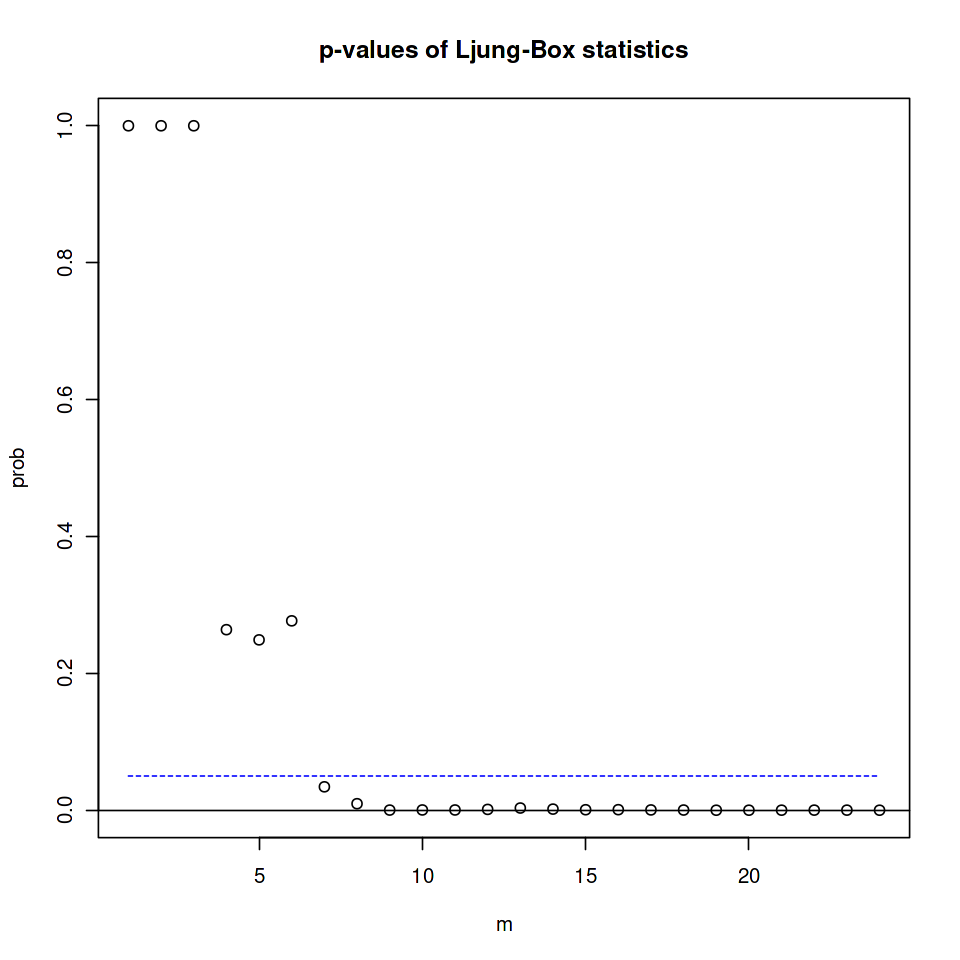

In [34]:
options(repr.plot.width = 8, repr.plot.height =8)
resi2=m2_mts$residuals
mq(resi2, adj=36) #Ajustamos los grados de libertad

**Modelo Refinado con MTS**

Constant term: 
Estimates:  0 0 0 0 
Std.Error:  0 0 0 0 
AR coefficient matrix 
AR( 1 )-matrix 
       [,1] [,2] [,3] [,4]
[1,] -0.110    0    0    0
[2,]  0.000    0    0    0
[3,] -0.712    0    0    0
[4,]  0.000    0    0    0
standard error 
       [,1] [,2] [,3] [,4]
[1,] 0.0329    0    0    0
[2,] 0.0000    0    0    0
[3,] 0.2832    0    0    0
[4,] 0.0000    0    0    0
AR( 2 )-matrix 
      [,1]     [,2]    [,3]    [,4]
[1,] 0.272  0.00000  0.0000 -0.0243
[2,] 0.000  0.00000  0.0000  0.0000
[3,] 0.000  0.00000  0.0000  0.1554
[4,] 0.439 -0.00962 -0.0361  0.0000
standard error 
       [,1]   [,2]   [,3]    [,4]
[1,] 0.0396 0.0000 0.0000 0.00979
[2,] 0.0000 0.0000 0.0000 0.00000
[3,] 0.0000 0.0000 0.0000 0.07076
[4,] 0.1612 0.0049 0.0183 0.00000
  
Residuals cov-mtx: 
                      resi                    
     0.06916045  0.7964631 0.2955451 0.1612436
resi 0.79646312 65.9615073 4.8661706 2.6771853
     0.29554511  4.8661706 5.2722566 1.2711235
     0.16124359  2.67718

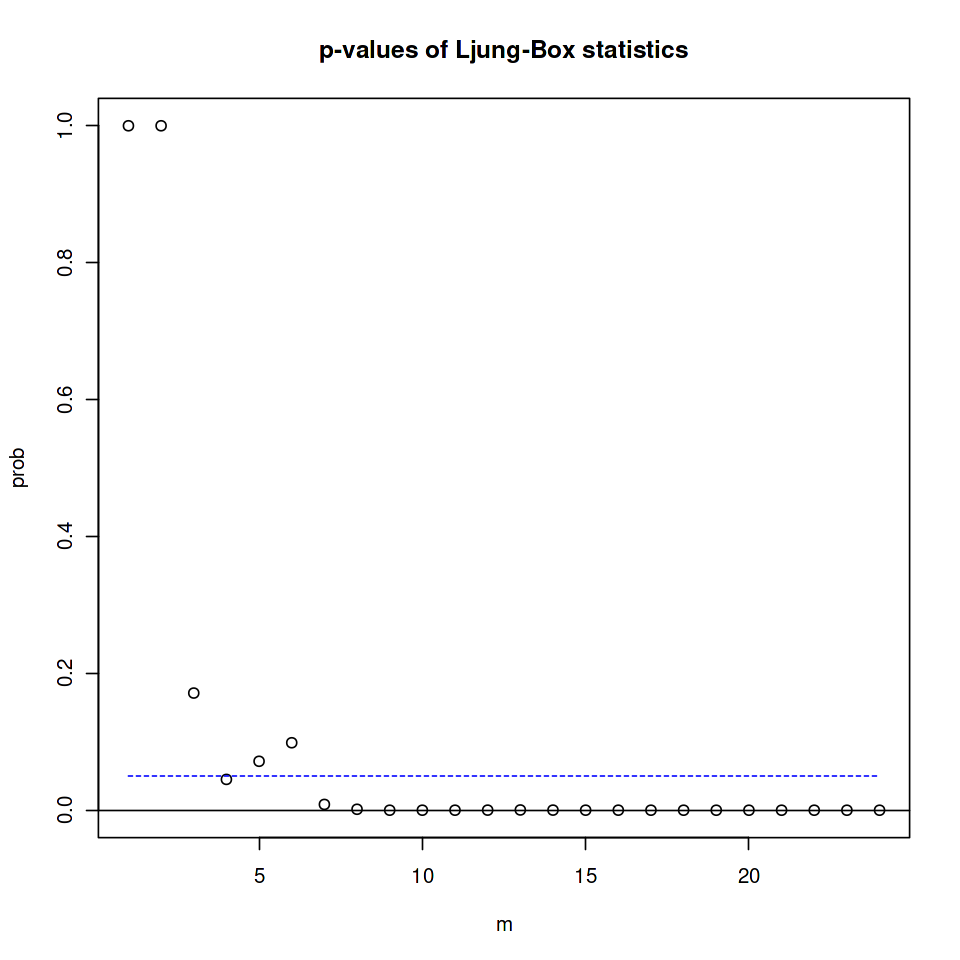

In [41]:
m3_mts=refVAR(m2_mts,thres = 1.96)
options(repr.plot.width = 8, repr.plot.height =8)
resi3=m3_mts$residuals
mq(resi3, adj=20)

**Metricas De Error on Test (Librearia MTS)**

In [40]:
library(forecast)

pred2<-VARpred(m3_mts,  h=h-1)
yardstick::rmse(data.frame(Y=as.matrix(ryld.testing.dif)), truth = RYLD, estimate =  pred2$pred[,1])
yardstick::mae(data.frame(Y=as.matrix(ryld.testing.dif)), truth = RYLD, estimate = pred2$pred[,1])
yardstick::rmse(data.frame(Y=as.matrix(ryld.testing.dif)), truth = RYLD, estimate =  pred2$pred[,2])
yardstick::mae(data.frame(Y=as.matrix(ryld.testing.dif)), truth = RYLD, estimate = pred2$pred[,2])
yardstick::rmse(data.frame(Y=as.matrix(ryld.testing.dif)), truth = RYLD, estimate =  pred2$pred[,3])
yardstick::mae(data.frame(Y=as.matrix(ryld.testing.dif)), truth = RYLD, estimate = pred2$pred[,3])
yardstick::rmse(data.frame(Y=as.matrix(ryld.testing.dif)), truth = RYLD, estimate =  pred2$pred[,4])
yardstick::mae(data.frame(Y=as.matrix(ryld.testing.dif)), truth = RYLD, estimate = pred2$pred[,4])

#MTSplot(pred2$pred)

orig  885 
Forecasts at origin:  885 
      ryld.training.dif tesla.training.dif tm.training.dif gm.training.dif
 [1,]         6.961e-02                  0       3.564e-01       5.704e-02
 [2,]        -6.868e-02                  0       6.232e-02      -7.487e-02
 [3,]         2.511e-02                  0       5.779e-02       1.765e-02
 [4,]        -1.965e-02                  0      -2.952e-02      -3.237e-02
 [5,]         8.568e-03                  0       1.674e-02       8.925e-03
 [6,]        -5.508e-03                  0      -1.113e-02      -7.550e-03
 [7,]         2.722e-03                  0       5.310e-03       3.152e-03
 [8,]        -1.616e-03                  0      -3.112e-03      -2.013e-03
 [9,]         8.422e-04                  0       1.641e-03       1.002e-03
[10,]        -4.837e-04                  0      -9.127e-04      -5.961e-04
[11,]         2.582e-04                  0       5.002e-04       3.100e-04
[12,]        -1.456e-04                  0      -2.765e-04    

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.1326616


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
mae,standard,0.09956909


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.1324517


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
mae,standard,0.09913028


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.138482


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
mae,standard,0.103573


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.1329532


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
mae,standard,0.09997954


[1] 885

ERROR: Error in plot(data_training$ID, data_training$RYLD, type = "l") + lines(data_testing$ID, : non-numeric argument to binary operator


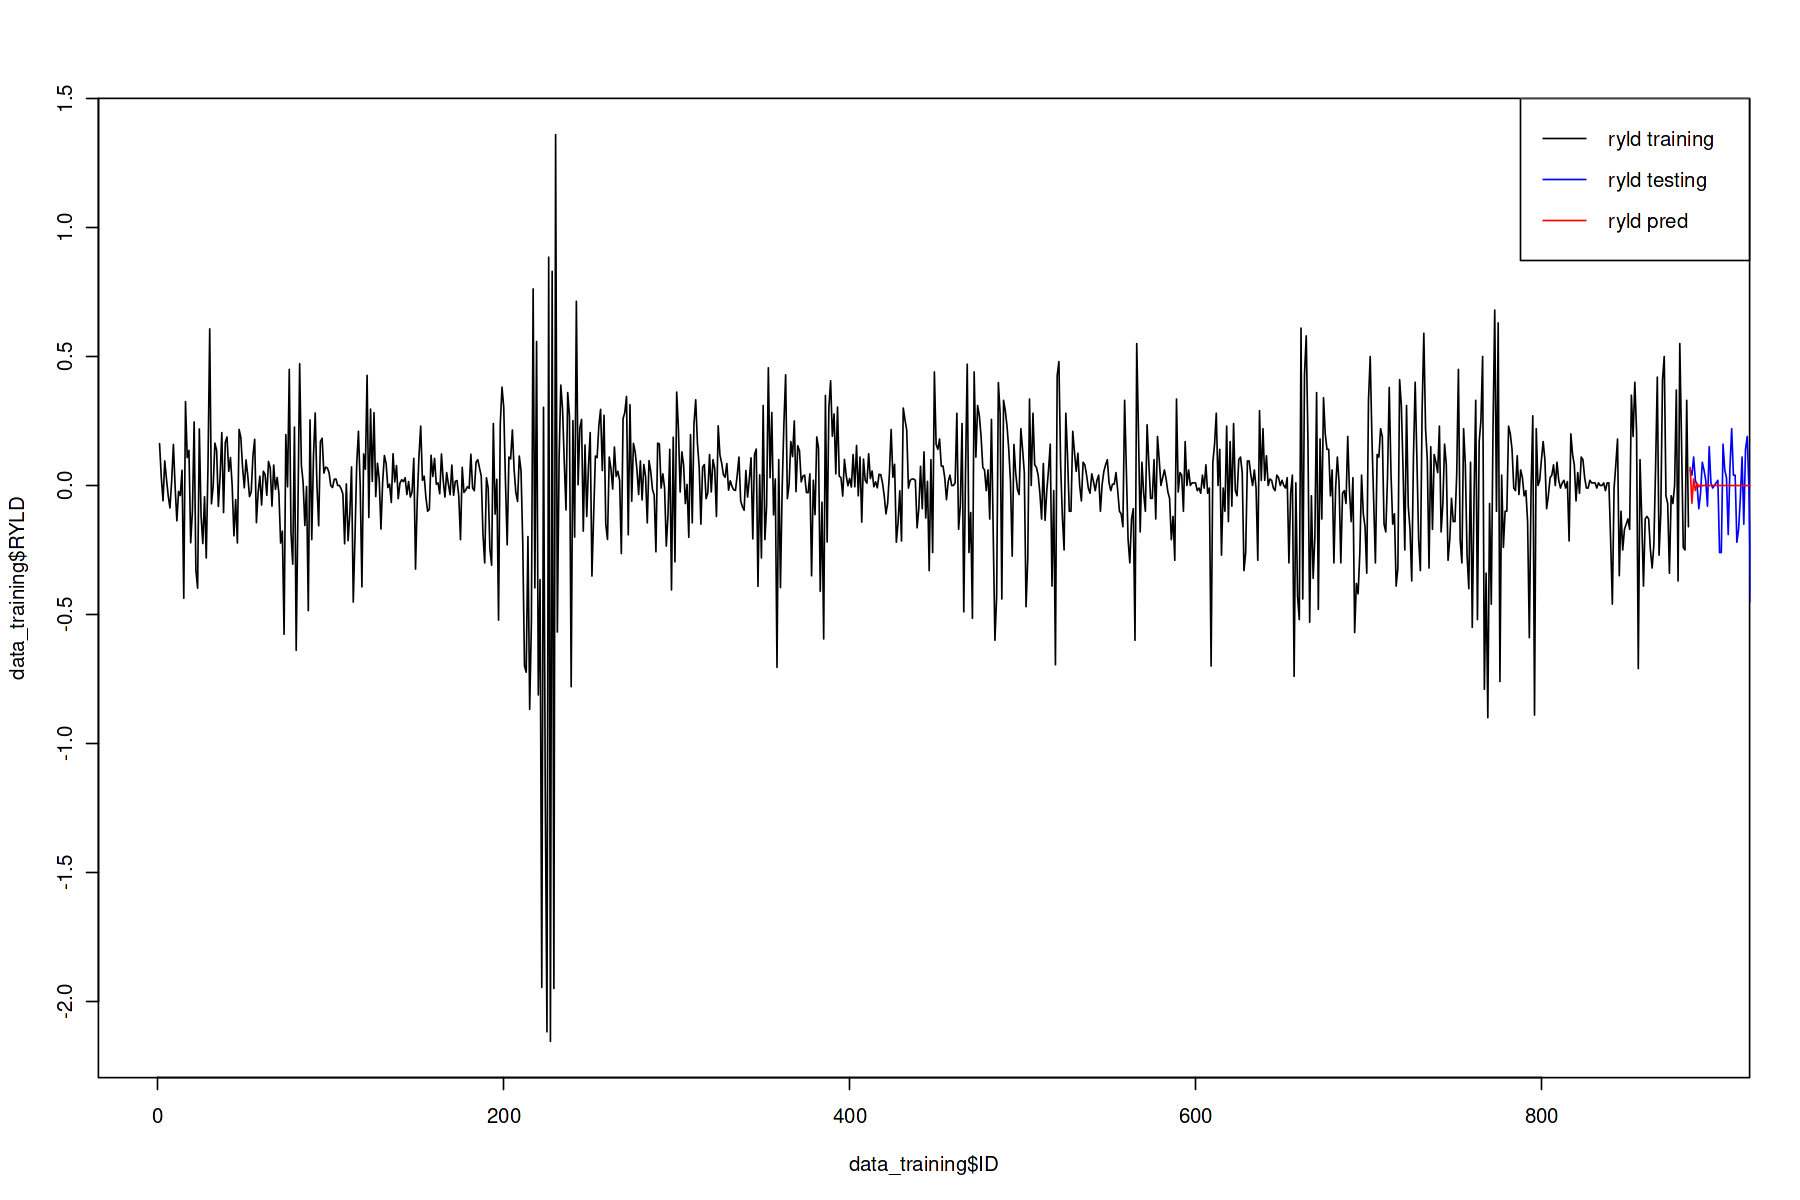

In [72]:
data_training= data.frame(Y=as.matrix(ryld.training.dif))
data_training <- cbind(ID = 1:nrow(data_training), data_training)  
nrow(data_training)

lim_inf<-nrow(data_training) +1
lim_sup<-lim_inf + nrow(data_testing) -1
data_testing= data.frame(Y=as.matrix(ryld.testing.dif))
data_testing <- cbind(ID = lim_inf:lim_sup, data_testing)  

data_testing$pred= pred2$pred[,1]

options(repr.plot.width = 15, repr.plot.height =10)
plot(data_training$ID, data_training$RYLD,type = "l") +
lines(data_testing$ID, data_testing$RYLD,type = "l", col='blue') +
lines(data_testing$ID, data_testing$pred, type = "l", col='red') +
legend("topright",                           
       c("ryld training", "ryld testing", "ryld pred"),
       lty = 1,
       col = c('black','blue','red'))